In [1]:
from skimage.io import imread
from skimage import img_as_float
from matplotlib import pyplot as plt
import numpy as np
from instaFilters import * # Import Chunlok's Filters

In [2]:
try:
    # Attempt to load the dataset
    with np.load('data.npz') as data:
        X = data['arr_0']
        y = data['arr_1']
except:
    # The dataset does not exist, so we regenerate
    
    # Set up a sample of random images: 
    img_count = 1000000 # 1 million
    sample_size = (img_count, 3, 3, 3) # 3x3 windows, each containing 3 channels
    images = np.random.random(sample_size)

    # The correct label for each "image" is the color at its center
    y = images[:, 1, 1, :]

    # Now we apply the filter to each of our images and store the filtered image
    X = np.zeros(images.shape)
    for i in range(images.shape[0]):
        thisImg = images[i]
        filtered = gingham(thisImg)
        X[i] = filtered
        
        if (i % (img_count / 100) == 0):
            print("%d%% done" % (100 * i / img_count))

    np.savez("data.npz", X, y)

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

model = keras.Sequential([
        keras.layers.Flatten(input_shape=(3, 3, 3)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(3)
])

optimizer = RMSprop(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 27)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1792      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 10,307
Trainable params: 10,307
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Truncate down to 1mil items
X = X[:1000000]
y = y[:1000000]

In [13]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('\n')
        print('.', end='')

EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)



........

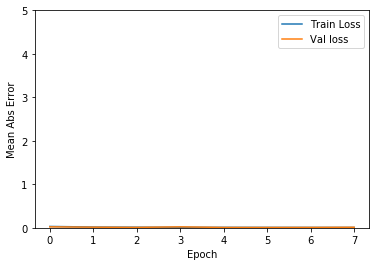

In [6]:
# Now actually train the model
history = model.fit(X, y, epochs=EPOCHS,
                    validation_split=0.1, verbose=0,
                    callbacks=[early_stop, PrintDot()])

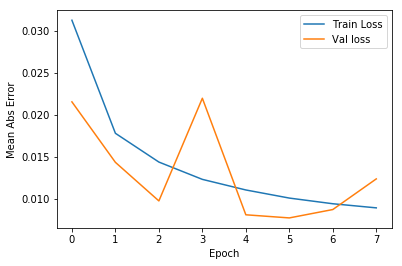

In [14]:
plot_history(history)

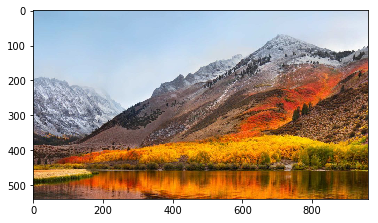

In [7]:
# Okay, so our model is trained. Now we test on an existing image.
# First we load and show the original image:
# Load the unfiltered image
im = img_as_float(imread("photo.jpg"))
plt.imshow(im)
plt.show()

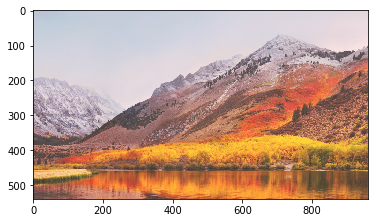

In [8]:
# Then we apply the filter on the image
filtIm = gingham(im)
plt.imshow(filtIm)
plt.show()

In [9]:
# We split the filtered image into 3x3 windows and store all of those.
# We disregard the edge pixels, unfortunately
dataPts = np.zeros((filtIm.shape[0] - 2, filtIm.shape[1] - 2, 3, 3, 3))
                   
for cent_y in range(0, dataPts.shape[0]):
    for cent_x in range(0, dataPts.shape[1]):
        # Get the window
        orig_y = cent_y + 1
        orig_x = cent_x + 1
        
        sample = filtIm[orig_y-1:orig_y+2, orig_x-1:orig_x+2, :]        
        dataPts[cent_y, cent_x] = sample

In [10]:
# We run the predictions
outData = model.predict(dataPts.reshape(-1, 3, 3, 3))

# And we convert the predictions to the correct shape
outIm = outData.reshape(dataPts.shape[0], dataPts.shape[1], 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


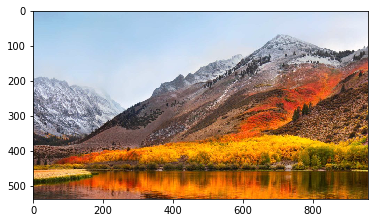

In [11]:
# Finally we display the now-unfiltered image
plt.imshow(outIm)
plt.show()

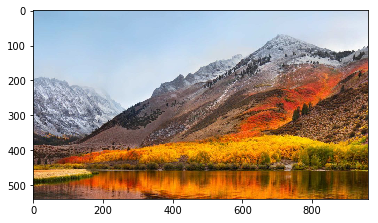

In [12]:
# This is what the original looked like: similar?
plt.imshow(im)
plt.show()

In [15]:
# Great! Save the model.
model.save('gingham.h5')